In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import statsmodels.api as sm
import statsmodels.tsa.api as ts
import datetime

## Data Analysis

In [12]:
a = torch.Tensor([[[1,2,0],[0,1,2]],[[1,2,0],[0,1,2]]])

a.flatten()[a.flatten().nonzero()]

tensor([[1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.]])

In [59]:
data = pd.read_csv("~/Documents/SCALE/Misc Code/Masked_CGMrecords_forLucas_fixed.csv")

print(f"data shape: {data.shape}")
print(f"number of patients: {len(data.patientid.unique())}")
data.head()

data shape: (2899516, 13)
number of patients: 4585


,patientid,dob,date,counts,egv_sum,egv_squared_sum,tir_counts,below_70_counts,below_55_counts,above_180_counts,above_250_counts,egv,cv
0,0004cf0f-d4ee-4f40-b373-c2c80d0fcc7f,1959-06-29T00:00:00Z,2022-09-22T00:00:00Z,212,36578,6509836,120,0,0,92,0,172.537736,0.177881
1,0004cf0f-d4ee-4f40-b373-c2c80d0fcc7f,1959-06-29T00:00:00Z,2022-09-23T00:00:00Z,288,47028,7940170,219,0,0,69,1,163.291667,0.184639
2,0004cf0f-d4ee-4f40-b373-c2c80d0fcc7f,1959-06-29T00:00:00Z,2022-09-24T00:00:00Z,288,40768,6144408,234,3,0,51,0,141.555556,0.254836
3,0004cf0f-d4ee-4f40-b373-c2c80d0fcc7f,1959-06-29T00:00:00Z,2022-09-25T00:00:00Z,288,38512,5367560,273,1,0,14,0,133.722222,0.205937
4,0004cf0f-d4ee-4f40-b373-c2c80d0fcc7f,1959-06-29T00:00:00Z,2022-09-26T00:00:00Z,288,43632,7281122,221,0,0,67,21,151.500000,0.319129


In [60]:
data.loc[:,"age"] = data.loc[:,"date"].str.slice(0,4).astype(int) - data.loc[:,"dob"].str.slice(0,4).astype(int)
data.loc[:,"weekday"] = data.loc[:,"date"].str.slice(0,10).apply(lambda x: (datetime.datetime.strptime(x,"%Y-%m-%d").weekday() + 1) % 7)
data.loc[:,"month"] = data.loc[:,"date"].str.slice(5,7).astype(int)

## Sample Trajectory

In [61]:
patientid = '2c38d8cb-ab92-416d-a4cb-39ed7dd63549'

patient_data = data[data["patientid"] == patientid]

print(f"trajectory length for patient {patientid}: {len(patient_data)}")

trajectory length for patient 2c38d8cb-ab92-416d-a4cb-39ed7dd63549: 630


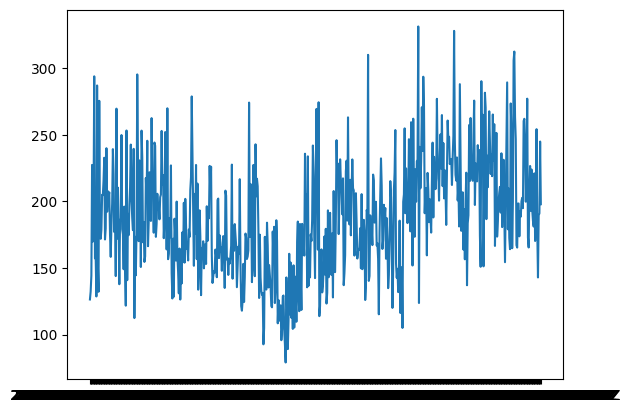

In [62]:
plt.plot(patient_data.date, patient_data.egv)

In [ ]:
import Hedge.models as m

In [85]:
device = "cpu"

covariates = ["age","weekday","month","tir_counts","below_55_counts","egv"]

X = torch.Tensor(patient_data[covariates].to_numpy()).to(device)
y = torch.Tensor(patient_data["egv"].to_numpy()).to(device)

dim = X.shape[-1]
start = 20
end = len(X)

n_models = 3

In [103]:
def run_sim(start, end, X, y = None, save = False):

    dim = X.shape[-1]
    forecasts = torch.zeros(dim,end-start,n_models).to(device)

    node = m.neural_ode(dim,device).to(device)
    rnn = m.RNN(dim).to(device)
    transformer = m.TransformerModel(input_dim = dim).to(device)

    for i,k in enumerate(range(start,end)):

        print(k)

        future = X[k].reshape((1,-1))
        x_train = X[start-1:k]
        y_train = y[start-1:k] if torch.is_tensor(y) else None


        if i < 5:

            continue        

        t = torch.linspace(0,1,i)

        if k < 300:

            if k%20 == 0:

                m.train_lstm(rnn,x_train,y_train)

            if k%100 == 0:

                m.train_node(t, node, X = x_train,y = y_train)
                m.train_transformer(transformer, x_train,y_train, epochs = 20)


            forecasts[:,i,0] = m.node_forecast(node, future)
            forecasts[:,i,1] = rnn(future)
            forecasts[:,i,2] = transformer(future)

        else:

            if k%100 == 0:

                m.train_node(t, node, X = x_train,y = y_train)
                m.train_transformer(transformer, x_train,y_train, epochs = 20)

            if k%30 == 0 and (i+30 < end - start + 1):

                m.train_lstm(rnn,x_train,y_train)

                forecasts[:,i:i+30,0] = m.node_forecast(node, X[k:k+30]).T
                forecasts[:,i:i+30,1] = rnn(X[k:k+30]).T
                forecasts[:,i:i+30,2] = transformer(X[k:k+30]).T

            elif k%30 == 0:

                m.train_lstm(rnn,x_train,y_train)

                forecasts[:,i:,0] = m.node_forecast(node, X[k:end+1]).T
                forecasts[:,i:,1] = rnn(X[k:end+1]).T
                forecasts[:,i:,2] = transformer(X[k:end+1]).T


    if save:
        
        torch.save(node.state_dict(), "./models/neural_ode.pt")
        torch.save(rnn.state_dict(), "./models/lstm.pt")
        torch.save(transformer.state_dict(), "./models/transformer.pt")

    return forecasts            

In [128]:
def plot_losses(losses):

    losses = losses.cpu().detach()

    plt.plot(losses.cumsum(axis=1)[2,:,0], label = "Neural ODE")
    plt.plot(losses.cumsum(axis=1)[2,:,1], label = "RNN")
    plt.plot(losses.cumsum(axis=1)[2,:,2], label = "Transformer")
    #plt.plot(losses.cumsum(axis=1)[2,:,3], label = "SINDy")#
    plt.legend()
    plt.title("Cumulative Losses")
    plt.show()
    return None

In [129]:
def plot_forecasts(forecasts, y, ftl, patientid):

    forecasts = forecasts.cpu().detach()
    y = y.cpu().detach()
    ftl = ftl.cpu().detach()

    plt.plot(y[start:end+1], c = "black", label = "True Value")
    plt.plot(forecasts[-1,:end-start+1,0], c = "lightblue", label = "Neural ODE")
    plt.plot(forecasts[-1,:end-start+1,1], c = "orange", label = "RNN")
    plt.plot(forecasts[-1,:end-start+1,2], c = "blue", label = "Transformer")
    plt.plot(ftl[-1,:end-start+1], "--", c = "red", label = "Hedge")
    plt.title(f"Estimate Glucose Forecasts for Patient {patientid}")
    plt.legend()
    plt.show()
    return None

In [104]:
X_noegv = X[:,:-1]
y_egv = None

In [107]:
forecasts_noegv = run_sim(start, end, X = X_noegv, y = y)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
2

In [176]:
eta = np.sqrt(np.log(n_models)/(end - start))

def full_loss_forecasts(forecasts, y,start = start, end = end, eta = eta):

    dim = forecasts.shape[0]

    losses = torch.zeros((dim,end-start,n_models)).to(device)

    for i in range(n_models):

        losses[:,:,i] = ((forecasts[:,:,i] - y[start:end].T)**2)

    losses = losses / losses.max()

    dim = forecasts.shape[0]

    weights = torch.exp(-eta * losses.cumsum(axis=1))
    leader = weights.argmax(axis=2)

    ftl = torch.zeros(forecasts.shape[:-1])
    ftl_losses = torch.zeros(forecasts.shape[:-1])

    for v in range(dim):

        ftl[v,:] = torch.Tensor([forecasts[v,i,j] for i,j in zip(range(end),leader[v,:])])
        ftl_losses[v,:] = torch.Tensor([losses[v,i,j] for i,j in zip(range(end),leader[v,:])])

    return ftl, losses, ftl_losses, leader

In [139]:
def leader_loss_forecasts(forecasts, y, start = start, end = end, eta = eta):

    dim = forecasts.shape[0]

    losses = torch.ones((dim,end-start,n_models)).to(device)
    leaders = torch.zeros(end-start)

    ftl = torch.zeros(forecasts.shape[:-1])

    for v in range(dim):

        weights = torch.ones(n_models)
        p = weights / weights.sum()

        for i,k in enumerate(range(start, end)):

            leader = torch.multinomial(p, num_samples=1)
            leaders[i] = leader
            ftl[v,i] = forecasts[v,i,leader]
            ell = (ftl[v,i] - y[k])**2
            losses[v,i,leader] = ell
            losses[v,i,:] = losses[v,i,:] / losses[v,i,:].sum()

            weights = weights * torch.exp(-eta * losses[v,i,:])
            p = weights / weights.sum()

    return ftl, losses, leaders

In [177]:
ftl_noegv,losses_noegv, ftl_losses_noegv, leader_noegv = full_loss_forecasts(forecasts_noegv, y)

In [178]:
ftl2_noegv, losses2_noegv, leader2_noegv = leader_loss_forecasts(forecasts_noegv, y)

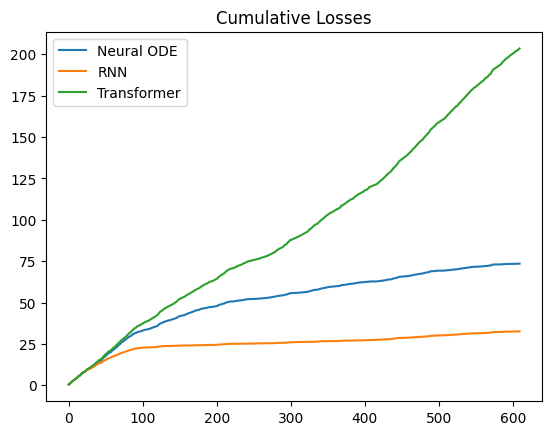

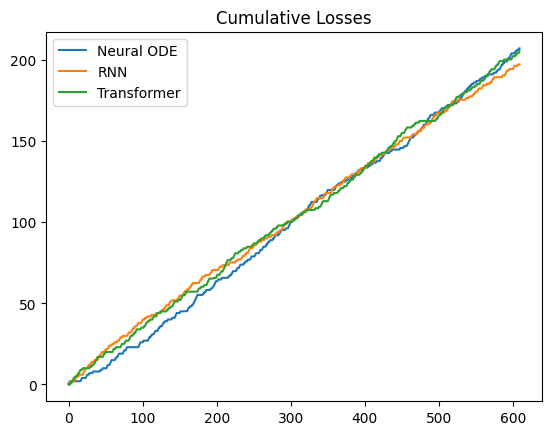

In [179]:
plot_losses(losses_noegv)
plot_losses(losses2_noegv)

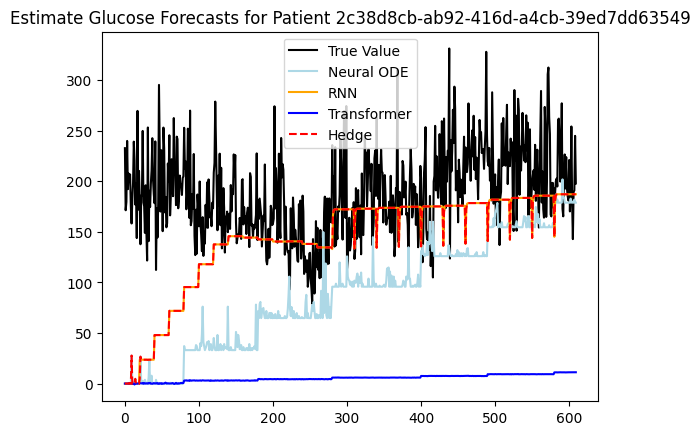

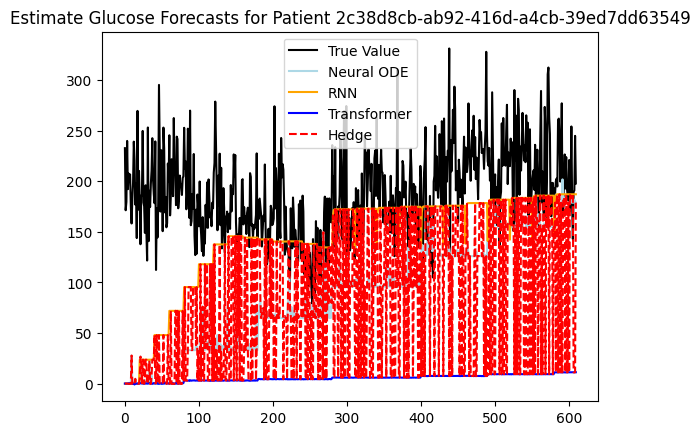

In [142]:
plot_forecasts(forecasts_noegv, y, ftl_noegv, patientid)
plot_forecasts(forecasts_noegv, y, ftl2_noegv, patientid)

In [117]:
forecasts = run_sim(start, end, X = X, y = None)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
2

In [180]:
ftl, losses, ftl_losses, leader = full_loss_forecasts(forecasts, y)
ftl2, losses2, leader2 = leader_loss_forecasts(forecasts, y)

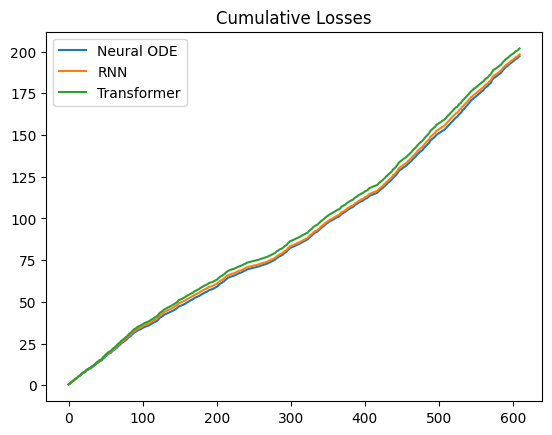

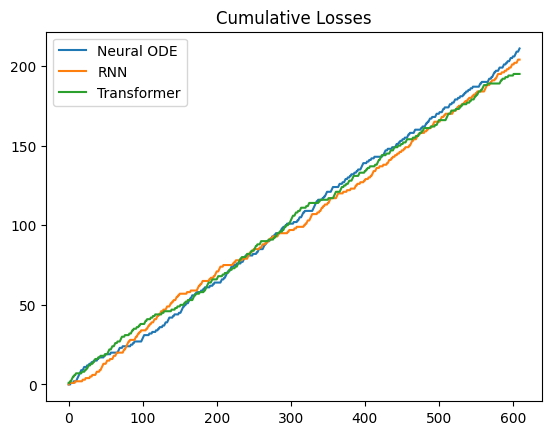

In [182]:
plot_losses(losses)
plot_losses(losses2)

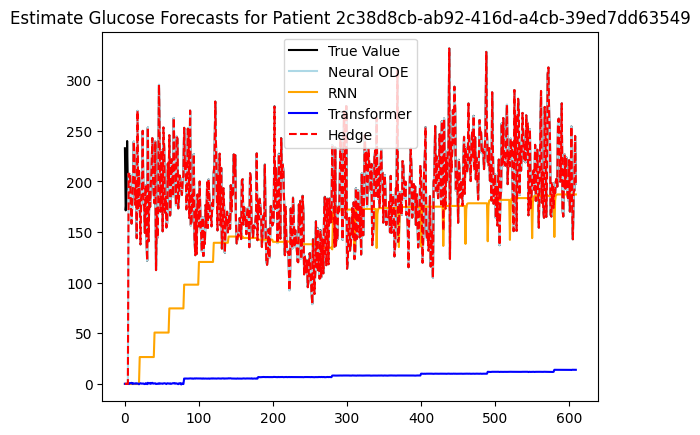

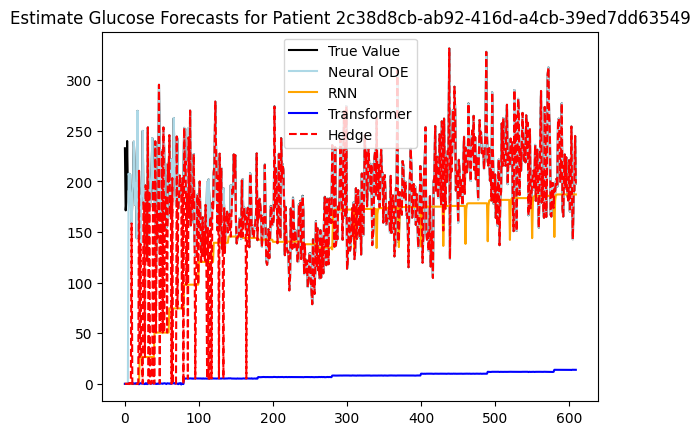

In [145]:
plot_forecasts(forecasts, y, ftl, patientid)
plot_forecasts(forecasts, y, ftl2, patientid)

In [162]:
def get_patientid(min_len = 300, max_len = 800):

    patient_lens = data.groupby("patientid")["egv"].count()
    possible_patients = patient_lens[(patient_lens >= min_len) & (patient_lens <= max_len)].index

    patientid = np.random.choice(possible_patients)

    print(patient_lens[patientid])

    return patientid


In [167]:
def get_patient_data(data, pid,covariates):

    patient_data = data[data["patientid"] == pid]
    X = torch.Tensor(patient_data[covariates].to_numpy()).to(device)
    y = torch.Tensor(patient_data["egv"].to_numpy()).to(device)

    return X,y

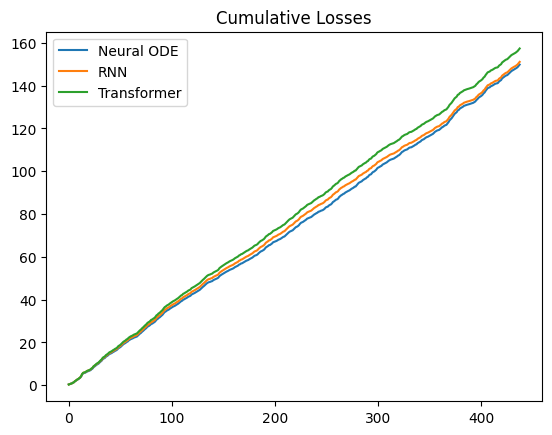

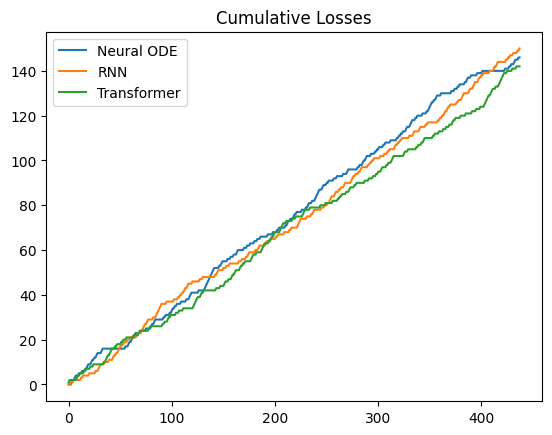

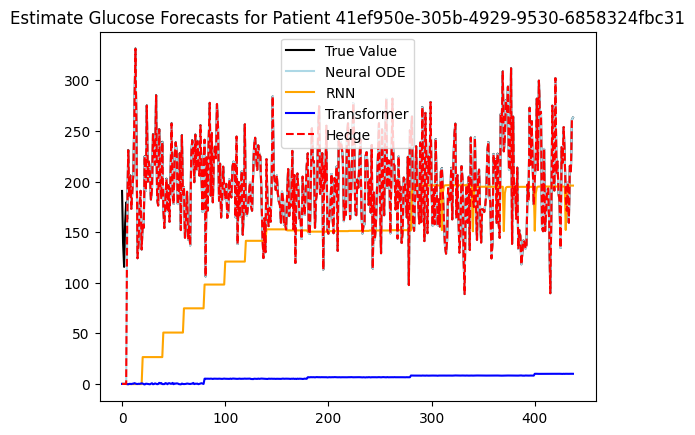

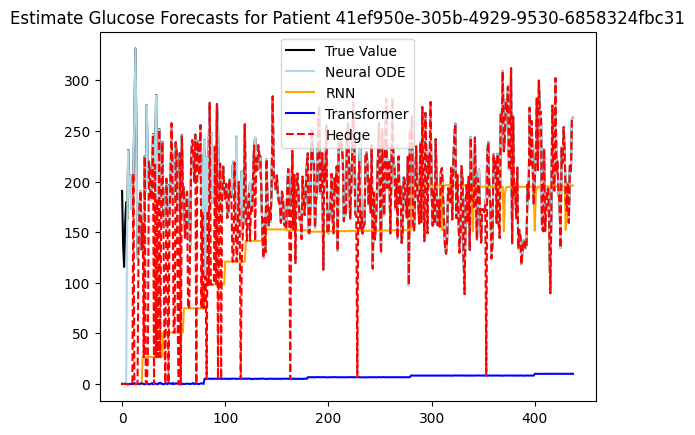

In [185]:
pid = get_patientid()

Xi, yi = get_patient_data(data, pid, covariates)

end = len(Xi)

forecastsi = run_sim(start, end, Xi, y = None)

ftli, lossesi, ftl_lossesi, leaderi = full_loss_forecasts(forecastsi, yi, end = end)
ftl2i, losses2i, leader2i = leader_loss_forecasts(forecastsi, yi, end = end)

plot_losses(lossesi)
plot_losses(losses2i)

plot_forecasts(forecastsi, yi, ftli, pid)
plot_forecasts(forecastsi, yi, ftl2i, pid)

## Confidence Bands with Marginal Coverage (Adapative Conformal Inference)

In [186]:
def make_confidence_bands(y_train, yhat_train, y_cal, yhat_cal, alpha = 0.05):

    S = lambda y_hat,y: np.abs(y_hat - y)
    Q = lambda p,cal_scores: np.sort(cal_scores)[int(p * len(cal_scores))-1]

    cal_scores = S(y_cal, yhat_cal)

    alpha_t = alpha
    intervals = np.zeros((len(yhat_train),2))

    err = 0
    gamma = 0.005

    for i in range(len(y_train)):

        y = y_train[i]
        yhat = yhat_train[i]

        quantile = Q(1-alpha_t, cal_scores)

        intervals[i,:] = np.array([(yhat - quantile),(yhat + quantile)])

        if intervals[i,0] <= y or y <= intervals[i,1]:

            err = 0
        else:
            err = 1

        alpha_t += gamma*(alpha - err)
    
    return intervals

In [205]:
y_train = y[start:len(X)].detach()
y_cal = yi[start:len(Xi)].detach()

yhat_train = ftl2[-1,:].detach()
yhat_cal = ftl2i[-1,:].detach()

intervals = make_confidence_bands(y_train,yhat_train, y_cal,yhat_cal)

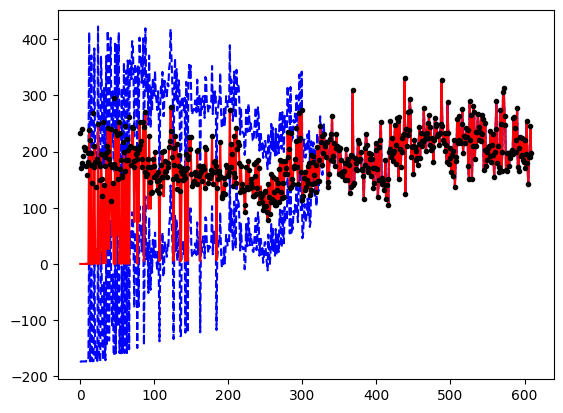

In [211]:
plt.plot(intervals[:,0], "--",c = "blue")
plt.plot(intervals[:,1], "--",c = "blue")
plt.plot(yhat_train, c = "red")
plt.plot(y_train, ".",c = "black")